In [1]:
import nengo
import nengolib
import nengo_spa as spa
import string
import numpy as np
import scipy
%pylab inline
import pylab

from nengo.utils.matplotlib import rasterplot
from nengo.dists import Choice
from nengo.utils.ensemble import response_curves, tuning_curves

import matplotlib.collections as mcol

%run ../UTC_model/dashedlines.py
%run ../UTC_model/UTC.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['lines.marker'] = ''
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3


## Neural Engineering Framework demo

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Varying bias ($\\beta$)')

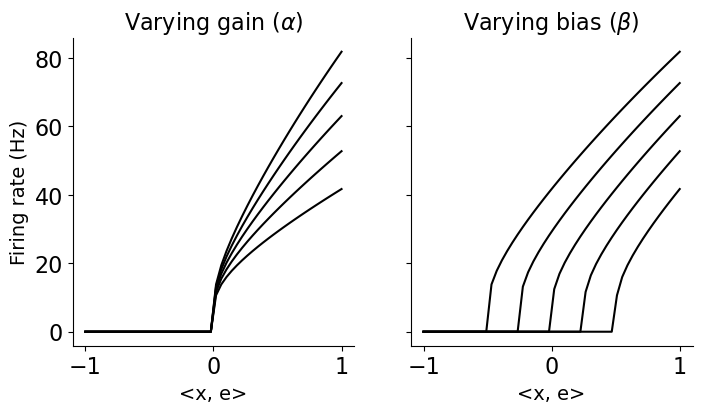

In [3]:
# Tuning curves: bias and intercept
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# vary gain (alpha)
model = nengo.Network()
with model:
    ens_1d = nengo.Ensemble(5, dimensions=1)
    
    ens_1d.bias = Choice([1])  # All neurons have x-intercept -0.2
    ens_1d.encoders = Choice([[1]])  # All neurons have encoder [1]
    ens_1d.gain = np.linspace(0.5, 1.5, num=5)

with nengo.Simulator(model) as sim:
    ax1.plot(*tuning_curves(ens_1d, sim), color='black')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel("Firing rate (Hz)")
ax1.set_xlabel("<x, e>")
ax1.set_title(r'Varying gain ($\alpha$)')

# vary intecept
model = nengo.Network()
with model:
    ens_1d = nengo.Ensemble(5, dimensions=1)
    
    ens_1d.bias = np.linspace(0.5, 1.5, num=5)  # All neurons have x-intercept -0.2
    ens_1d.encoders = Choice([[1]])  # All neurons have encoder [1]
    ens_1d.gain = Choice([1])

with nengo.Simulator(model) as sim:
    ax2.plot(*tuning_curves(ens_1d, sim), color='black')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("<x, e>")
ax2.set_title(r'Varying bias ($\beta$)')

#fig.savefig('gain_bias.png', dpi=400, bbox_inches='tight')
#fig.savefig('gain_bias.tiff', dpi=1000, bbox_inches='tight')

In [4]:
#parameters
#inputs = np.concatenate([np.zeros(100), np.ones(900)])
#inputs = nengo.processes.PresentInput(inputs, presentation_time = 0.001)
process = nengo.processes.WhiteSignal(30.0, high=1.5, y0=0)
tau_probe = 0.01  # to filter the spikes
n_neurons_pq = 100
q = 10
theta = 2

with nengolib.Network(seed=0) as model:
    LMT = nengolib.networks.RollingWindow(theta=theta, n_neurons=n_neurons_pq*q, 
        dimensions=q, process=None, legendre=True, neuron_type=nengo.LIF(), 
        realizer=nengolib.signal.realizers.Identity())
    
    a = nengo.Ensemble(n_neurons=100, dimensions=1, max_rates=nengo.dists.Uniform(20, 50))
    b = nengo.Ensemble(n_neurons=100, dimensions=1, max_rates=nengo.dists.Uniform(20, 50))
    
    stim = nengo.Node(output = process)

    nengo.Connection(stim, LMT.input, synapse=None)
    nengo.Connection(stim, a, synapse=0.05)
    nengo.Connection(stim, b, function=lambda x: x**2, synapse=0.05)
    
    p_stim_unfiltered = nengo.Probe(stim, synapse=None)
    p_stim = nengo.Probe(stim, synapse=None)
    p_a = nengo.Probe(a, synapse=0.05)
    p_b = nengo.Probe(b, synapse=0.05)
    p_a_spikes = nengo.Probe(a.neurons, 'spikes')
    p_x = nengo.Probe(LMT.state, synapse=tau_probe)  # for later analysis
    
with nengo.Simulator(model, seed=1) as sim:
    sim.run(5.0)

/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

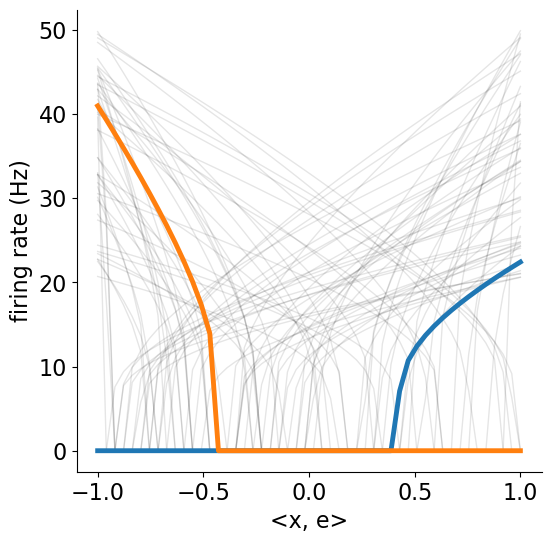

In [5]:
i = 17

fig, ax = plt.subplots(figsize=(6, 6))
xrange, activity = nengo.utils.ensemble.tuning_curves(a, sim)
tuning_plot = ax.plot(xrange, activity, lw=1, alpha=0.1, color='black')
tuning_plot = ax.plot(xrange, activity[:, i:i+2], lw=3.5)
ax.set_xlabel('<x, e>', size=16)
ax.set_ylabel('firing rate (Hz)', size=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(np.arange(-1, 1.5, 0.5))
ax.tick_params(axis='both', which='major', labelsize=16)

#fig.savefig('tuning_curves_highlighted.png', dpi=400)
#fig.savefig('tuning_curves_highlighted.tiff', dpi=1000, bbox_inches='tight')

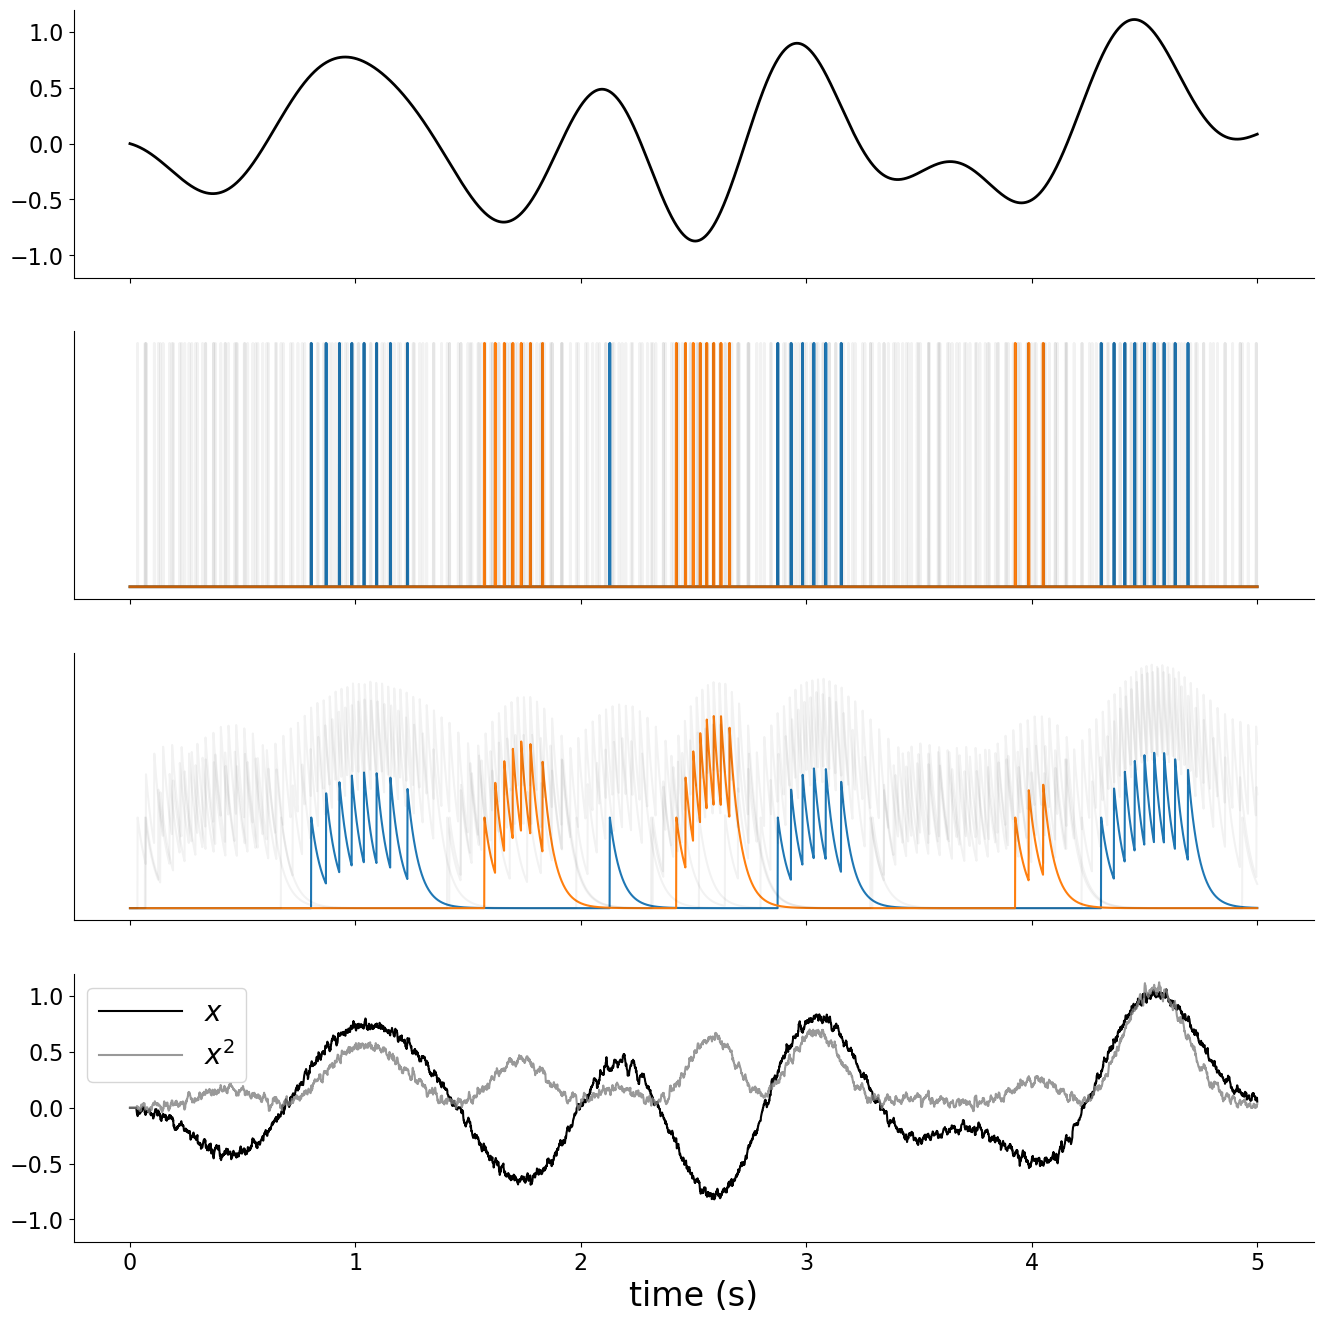

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 16), 
                                         sharex=True)

ax1.plot(sim.trange(), sim.data[p_stim],
         color='black', lw=2)
ax2.plot(sim.trange(), sim.data[p_a_spikes][:,i:i+2]/1000, lw=2)
ax2.plot(sim.trange(), sim.data[p_a_spikes][:,2:7]/1000, lw=2,
         color='black', alpha=0.05)

ax3.plot(sim.trange(), nengo.Lowpass(0.05).filt(sim.data[p_a_spikes][:,i:i+2]))
ax3.plot(sim.trange(), nengo.Lowpass(0.05).filt(sim.data[p_a_spikes][:,2:7]),
         color='black', alpha=0.05)

ax4.plot(sim.trange(), sim.data[p_a], color='black', label='$x$')
ax4.plot(sim.trange(), sim.data[p_b], color='grey', alpha=0.8, label='$x^2$')

ax4.legend(fontsize=20)

ax4.set_xlabel('time (s)', size=24)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax4.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylim([-1.2, 1.2])
ax1.set_yticks([-1, -0.5, 0, 0.5, 1.])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_ylim([-1.2, 1.2])
ax4.set_yticks([-1, -0.5, 0, 0.5, 1.])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#fig.savefig('principles_1_2.svg')

(-1.1, 1.1, -2.1197219996760372, 44.51416199319678)

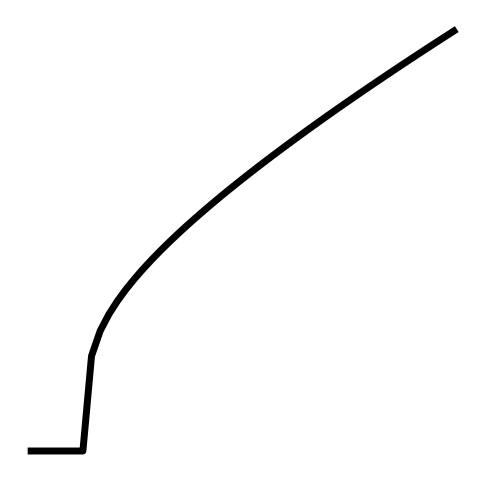

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
tuning_plot = ax.plot(xrange, activity[:, 2], lw=5, color='black')

ax.axis('off')

#fig.savefig('tuning_curve.svg', bbox_inches='tight')

(-25.0, 525.0, -0.9900663346622374, 20.791393027906985)

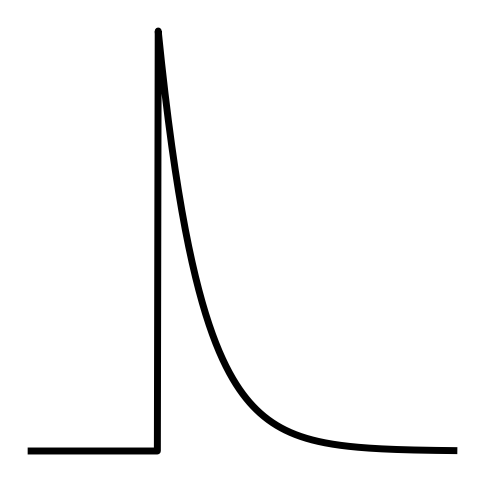

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(np.linspace(0, 500, num=500),
        nengo.Lowpass(0.05).filt(np.concatenate([np.zeros(150),
                                                  np.array([1000]), 
                                                  np.zeros(349)])),
        color='black', lw=5)

ax.axis('off')

#fig.savefig('lowpass.svg', bbox_inches='tight')

### Delaying an input

Text(0.5, 0, 'real time (s)')

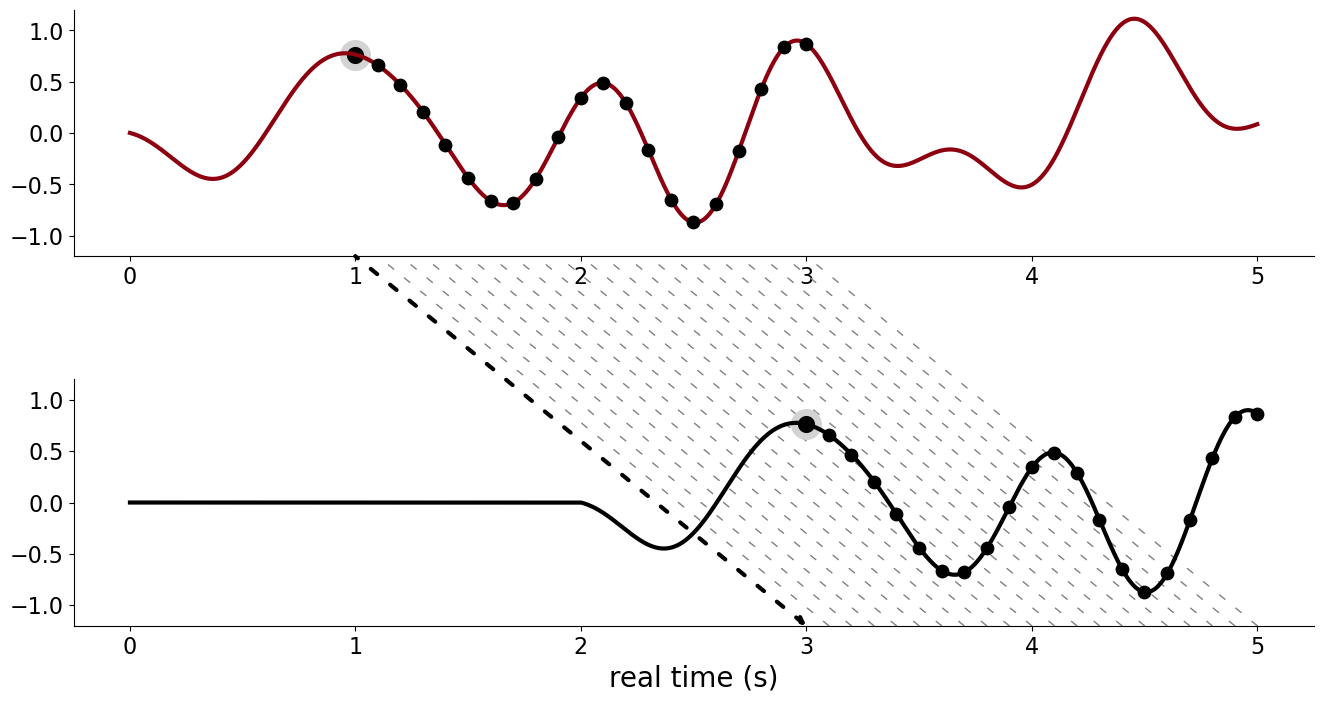

In [9]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(constrained_layout=False, figsize=(16, 8))
gs = fig.add_gridspec(2, 5, wspace=0, hspace=0.5)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:], sharey=ax1, sharex=ax1)

start = 1
ax1.plot(sim.trange(), sim.data[p_stim],
        color='#8c000fff', lw=3)

delay = int(theta*1000)
delayed_stim = np.concatenate([np.zeros(delay), sim.data[p_stim][:-delay].T[0]])
ax2.plot(sim.trange(), delayed_stim, color='black', lw=3)

ax1.set_ylim([-1.2, 1.2])
ax2.set_ylim([-1.2, 1.2])

# draw 'delay' lines and points
xyB = (start, -1.2)
xyA = (start+theta, -1.2)

con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA='data', coordsB='data',
                     axesA=ax2, axesB=ax1, color='black', ls=(0, (2, 4)),
                     arrowstyle='<-',
                     lw=3)
ax2.add_artist(con)

ax1.scatter(xyB[0], sim.data[p_stim][int(start*1000)], 
            c='black', s=300, lw=5, edgecolors='lightgrey')
ax2.scatter(xyA[0], sim.data[p_stim][int(start*1000)],
            c='black', s=300, lw=5, edgecolors='lightgrey')

for i in np.arange(start+0.1, start+theta+0.1, .1):
    xyB = (i, -1.2)
    xyA = (theta+i, -1.2)

    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA='data', coordsB='data',
                         axesA=ax2, axesB=ax1, color='grey', ls=(0, (5, 10)), zorder=0)

    ax2.add_artist(con)
    
    ax1.scatter(xyB[0], sim.data[p_stim][int(i*1000)], 
                color='black', s=80, zorder=100)
    ax2.scatter(xyA[0], sim.data[p_stim][int(i*1000)], 
                color='black', s=80, zorder=100)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.set_xlabel('real time (s)', fontsize=20)

#fig.savefig('delaying_input.svg')
#fig.savefig('delaying_input.tiff', dpi=1000, bbox_inches='tight')

(0.85, 3.05)

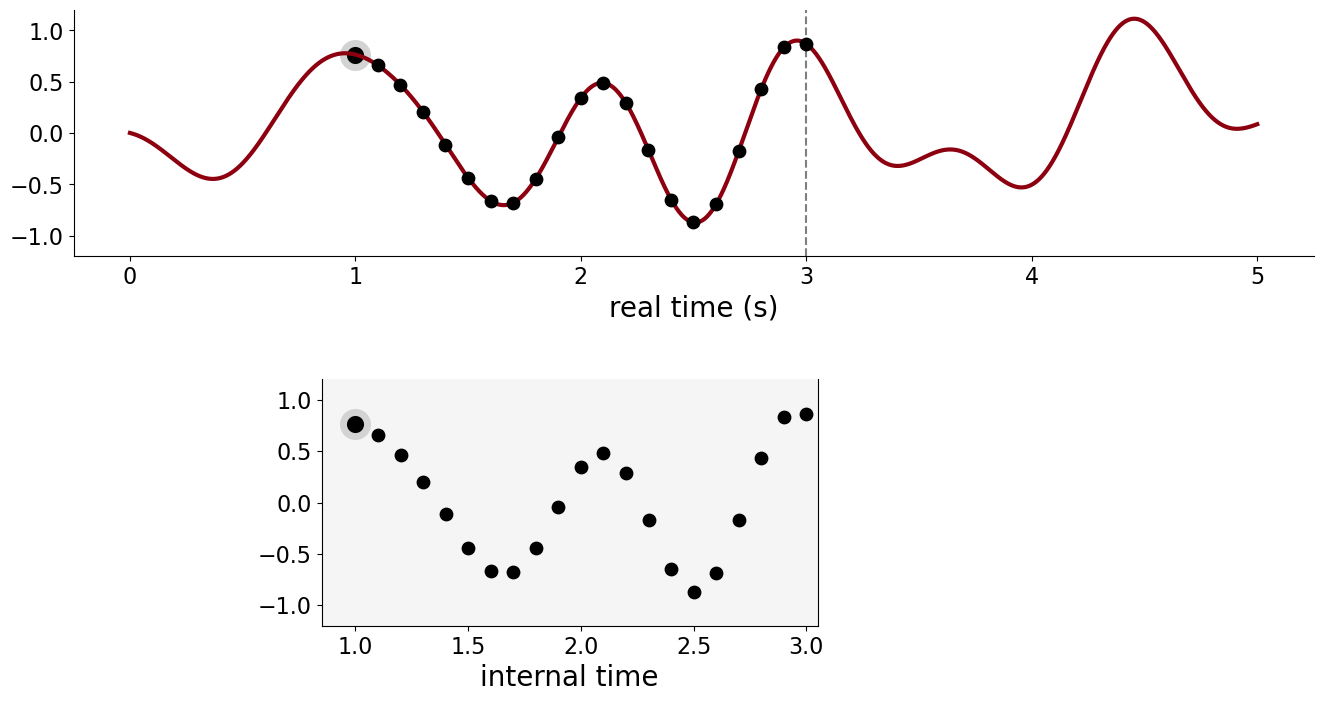

In [10]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(constrained_layout=False, figsize=(16, 8))
gs = fig.add_gridspec(2, 5, wspace=0, hspace=0.5)

ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,1:3], sharey=ax1)

start = 1
ax1.axvline(x = 3, linestyle='--', c='black', alpha=0.5)
ax1.plot(sim.trange(), sim.data[p_stim],
        color='#8c000fff', lw=3)

trange_internal = np.linspace(1, 3, num=2000)
#ax2.plot(trange_internal, 
#         sim.data[p_stim][int(start*1000): int((start+theta)*1000)],
#         c='black', lw=4, ls='-', label='estimated')

ax1.set_ylim([-1.2, 1.2])
ax2.set_ylim([-1.2, 1.2])

# draw 'delay' lines and points
xyB = (start, -1.2)
xyA = (start, -1.2)

ax1.scatter(xyB[0], sim.data[p_stim][int(start*1000)], 
            c='black', s=300, lw=5, edgecolors='lightgrey')
ax2.scatter(xyA[0], sim.data[p_stim][int(start*1000)],
            c='black', s=300, lw=5, edgecolors='lightgrey')

for i in np.arange(start+0.1, start+theta+0.1, .1):
    xyB = (i, -1.2)
    xyA = (i, -1.2)

    ax1.scatter(xyB[0], sim.data[p_stim][int(i*1000)], 
                color='black', s=80, zorder=100)
    ax2.scatter(xyA[0], sim.data[p_stim][int(i*1000)],
                color='black', s=80, zorder=100)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.set_xlabel('real time (s)', size=20)
ax2.set_xlabel('internal time', size=20)
#ax2.spines['right'].set_visible(False)

ax2.set_facecolor('whitesmoke')
ax2.set_xlim([np.min(trange_internal)-0.15, 
              np.max(trange_internal)+0.05])

#fig.savefig('infinite_memory_solution.svg')

### Legendre Memory Network

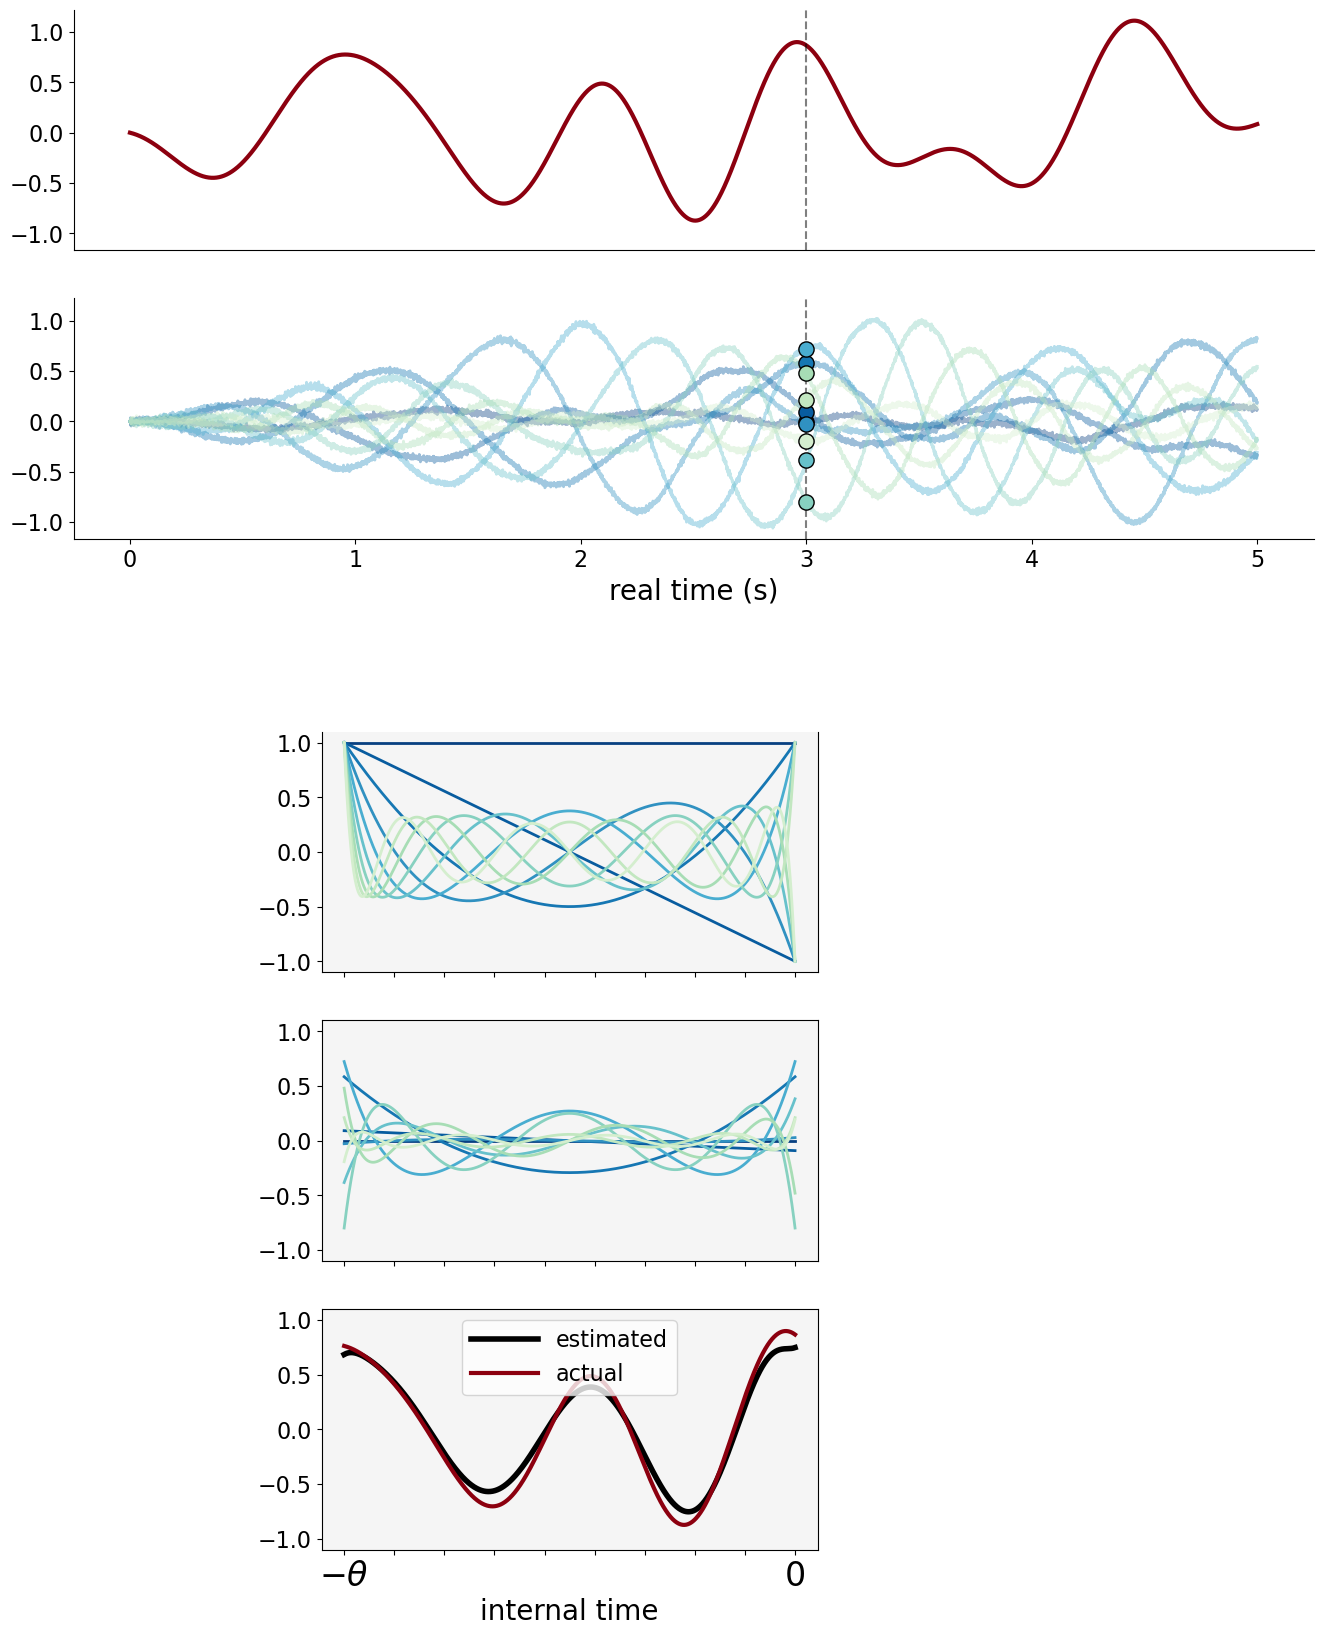

In [11]:
fig = plt.figure(constrained_layout=False, figsize=(16, 20))
gs = fig.add_gridspec(11, 5, wspace=0, hspace=0.5)

t = 3000
colors = plt.cm.GnBu(np.linspace(0.2, 1, num=q))[::-1]

ax1 = fig.add_subplot(gs[0:2,:])
ax2 = fig.add_subplot(gs[2:4,:], sharey=ax1)
ax3 = fig.add_subplot(gs[5:7,1:3])
ax4 = fig.add_subplot(gs[7:9,1:3], sharey=ax3)
ax5 = fig.add_subplot(gs[9:11,1:3], sharey=ax4)

ax1.plot(sim.trange(), sim.data[p_stim], c='#8c000fff', lw=3)
ax1.axvline(x = int(t/1000), linestyle='--', c='black', alpha=0.5)

B = LMT.basis()
ax2.axvline(x = int(t/1000), linestyle='--', c='black', alpha = 0.5)
for i in range(0,q):
    ax2.plot(sim.trange(), sim.data[p_x][:,i], lw=2, alpha=0.4,
             color=colors[i])
    ax2.scatter(int(t/1000), sim.data[p_x][t][i], 120, edgecolors='black', zorder=20,
                color=colors[i])
    
    ax3.plot(np.linspace(1, 3, num=1000), B[::-1, i], lw=2,
             color=colors[i], label='{}'.format(i))
    ax4.plot(np.linspace(1, 3, num=1000), sim.data[p_x][t,i] * B[::-1,i], lw=2,
             color=colors[i])

line = [[(0, 0)]]
# set up the proxy artist
lc = mcol.LineCollection(q * line, colors=colors)
# create the legend
#leg = ax3.legend([lc], ['dim'], handler_map={type(lc): HandlerDashedLines()},
#           handlelength=10, handleheight=0.75, fontsize=18, loc='lower left')

ax5.plot(np.linspace(1, 3, num=1000), 
         np.sum(sim.data[p_x][t] * B, axis=1)[::-1], 
         c='black', lw=4, ls='-', label='estimated')
ax5.plot(np.linspace(1, 3, num=int(theta*1000)), 
         sim.data[p_stim][t-int(theta*1000):t], c='#8c000fff', lw=3, label='actual')
ax5.legend(fontsize=16)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax4.tick_params(axis='both', which='major', labelsize=16)
ax5.tick_params(axis='both', which='major', labelsize=16)


ax1.set_xticks([])
ax2.set_xlabel('real time (s)', size=20)
ax3.set_xticks(np.linspace(1, 3, num=10))
ax3.set_xticklabels([])
ax4.set_xticks(np.linspace(1, 3, num=10))
ax4.set_xticklabels([])
ax5.set_xticks(np.linspace(1, 3, num=10))
ax5.set_xticklabels([r'$-\theta$', '', '', '', '', '', '', '', '', 0], 
                    size=24)
ax5.set_xlabel('internal time', size=20)

ax3.set_facecolor('whitesmoke')
ax4.set_facecolor('whitesmoke')
ax5.set_facecolor('whitesmoke')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
#ax3.spines['right'].set_visible(False)
#ax4.spines['top'].set_visible(False)
#ax4.spines['right'].set_visible(False)
#ax5.spines['top'].set_visible(False)
#ax5.spines['right'].set_visible(False)

#fig.savefig('legendre_memory_demo.svg')

### Legendre Memory Network with Semantic Pointers

In [12]:
# Set parameters
D = 32
dim = 9


def stimulus_function(t):
    if t > 0.25 and t < 0.75:
        return 'A'
    elif t > 0.75 and t < 1.25:
        return 'B'
    elif t > 1.25 and t < 1.75:
        return 'C'
    elif t > 1.75 and t < 2.25:
        return 'D'
    elif t > 2.25 and t < 2.75:
        return 'E'
    elif t > 2.75 and t < 3.25:
        return 'F'
    elif t > 3.25 and t < 3.75:
        return 'G'
    else:
        return 0

In [13]:
vocab = spa.Vocabulary(D)
letters = string.ascii_uppercase
letters = letters[0:7]
vocab.populate(";".join(letters))

In [14]:
%%capture

UTC().run(dimensions=dim,
                 D=D,
                 full_output=True,
                 gain_i=1.,
                 effective_theta=2.,
                 vocab=vocab,
                 task_type = 'retrospective',
                 stimulus_function=stimulus_function,
                 data_dir='utc_sp',
                 trial_duration=4.)

In [15]:
retrospective_data = pytry.read('utc_sp')

In [16]:
retrospective_dt = pd.DataFrame(retrospective_data)

In [17]:
# 
retro_state_input = []
retro_state = []

retro_state_input.append(retrospective_dt['state'].values[0])
retro_state.append(retrospective_dt['x'].values[0])

In [18]:
sp_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
temporal_window = []
history_matrix = []
for sp in sp_list:
    temp, hm = readout_window(np.moveaxis(retro_state[0], 1, 0), D, 2999, dim, vocab[sp].v)
    temporal_window.append(temp)
    history_matrix.append(hm)
    
hm = np.sum(np.asarray(history_matrix[0]), axis=2)

/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


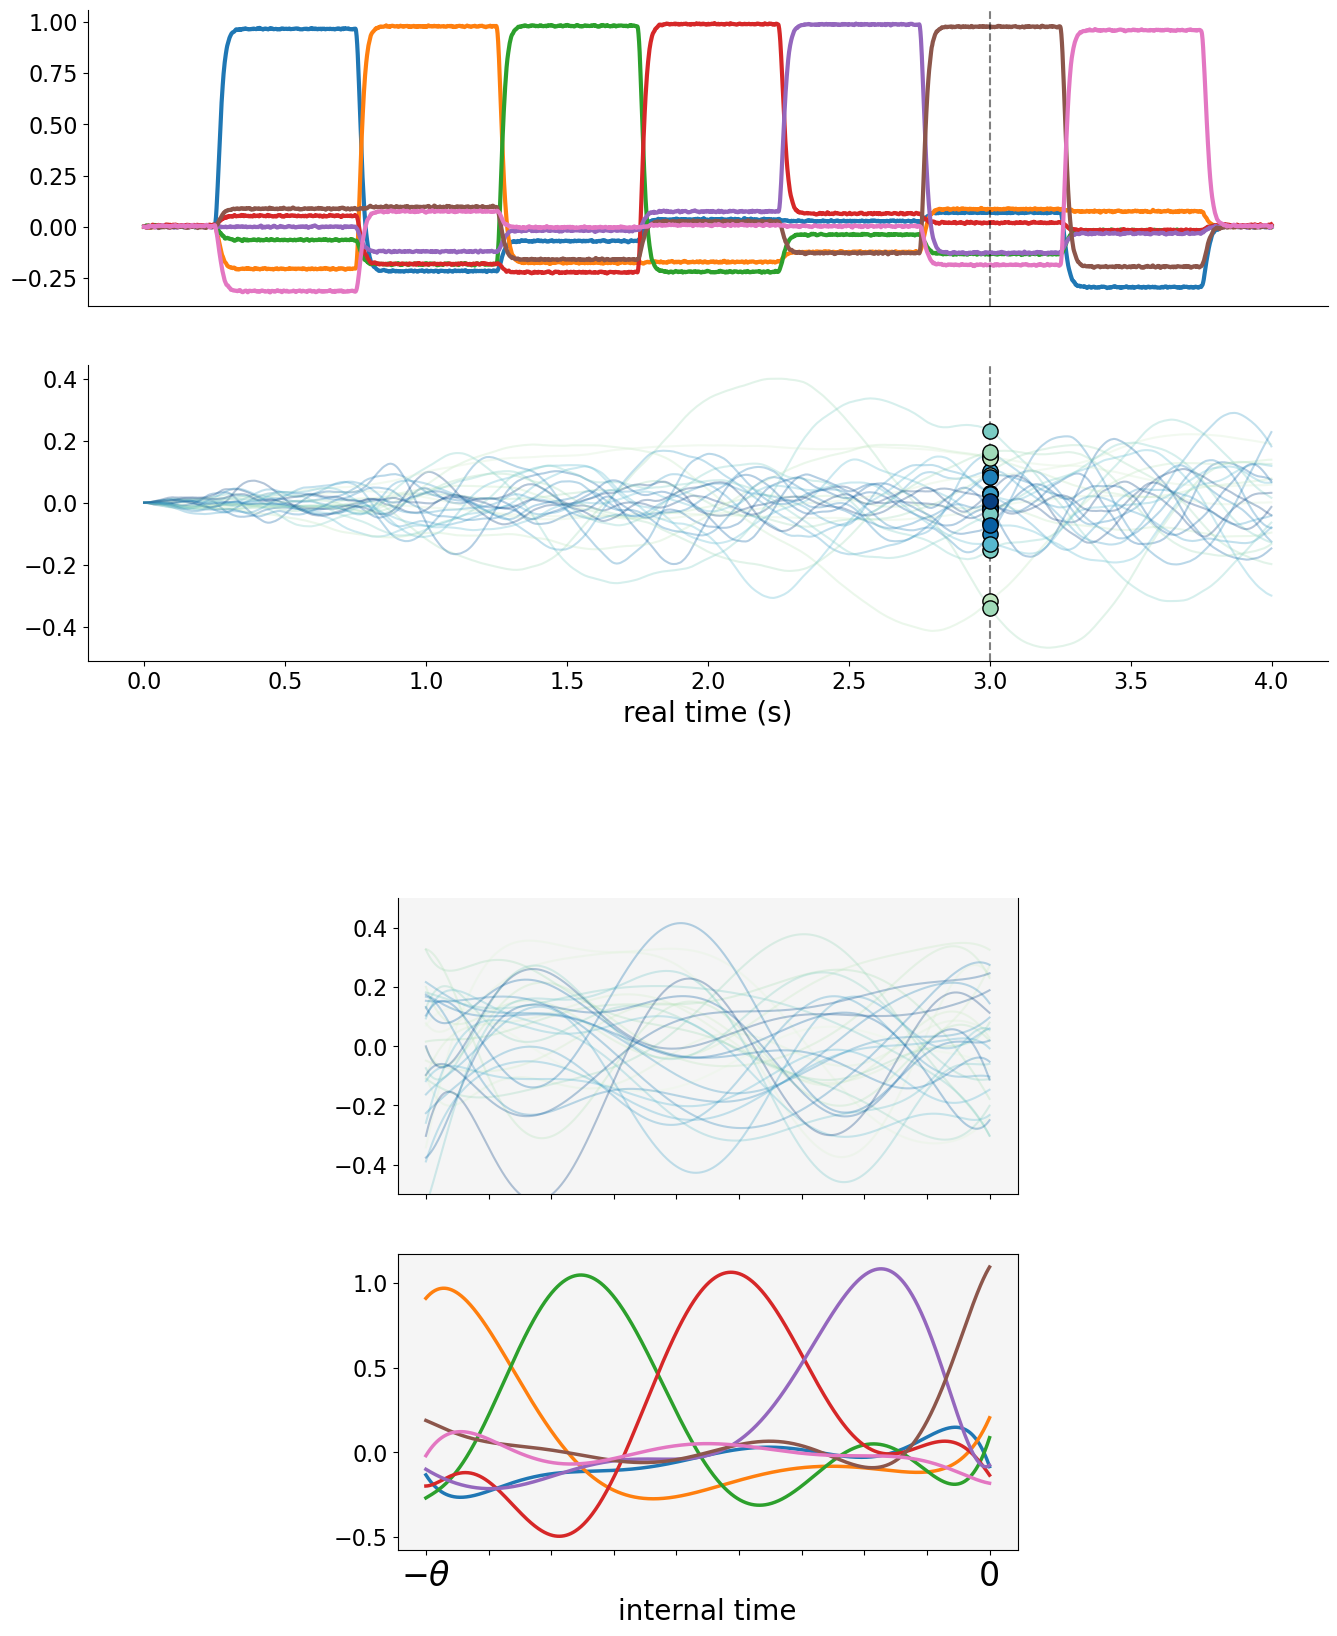

In [19]:
fig = plt.figure(constrained_layout=False, figsize=(16, 20))
gs = fig.add_gridspec(9, 4, wspace=0, hspace=0.5)

t = 3000
colors = plt.cm.GnBu(np.linspace(0.2, 1, num=dim))

ax1 = fig.add_subplot(gs[0:2,:])
ax2 = fig.add_subplot(gs[2:4,:])
ax3 = fig.add_subplot(gs[5:7,1:3])
ax4 = fig.add_subplot(gs[7:9,1:3])
#ax5 = fig.add_subplot(gs[9:11,1:3], sharey=ax4)

trange = np.arange(0, 4., 0.001)
ax1.plot(trange, 
         nengo.Alpha(0.01).filt(spa.similarity(retro_state_input[0], vocab)),
         lw=3)
ax1.axvline(x = int(t/1000), linestyle='--', c='black', alpha=0.5)

ax2.axvline(x = int(t/1000), linestyle='--', c='black', alpha = 0.5)
for i in [0, 1, 6]:
    for j in range(dim):
        ax2.plot(trange, 
                 nengo.Alpha(0.05).filt(np.moveaxis(retro_state[0], 1, 0))[:, i, j],
                 alpha=0.3, color=colors[j])
        
        ax2.scatter(int(t/1000), 
                    nengo.Alpha(0.05).filt(np.moveaxis(retro_state[0], 1, 0))[t, i, j], 120, edgecolors='black', zorder=20,
                    color=colors[j])
    
#for i in range(0, dim):
    #ax3.plot(np.linspace(1, 3, num=1000), B[::-1, i], lw=2,
    #         color=colors[i], label='{}'.format(i))
    #ax4.plot(np.linspace(1, 3, num=1000), sim.data[p_x][t,i] * B[::-1,i], lw=2,
    #         color=colors[i])

colors = plt.cm.GnBu(np.linspace(0.1, 1., num=D))
trange = np.linspace(1, 3, 1000)

for i in range(D):
    ax3.plot(trange, hm.T[:,i], color=colors[i], alpha=0.3)    

for i in range(len(sp_list)):
    ax4.plot(trange, temporal_window[i],
             lw=2.5, label=sp_list[i])

#line = [[(0, 0)]]
# set up the proxy artist
#lc = mcol.LineCollection(q * line, colors=colors)
# create the legend
#leg = ax3.legend([lc], ['dim'], handler_map={type(lc): HandlerDashedLines()},
#           handlelength=10, handleheight=0.75, fontsize=18, loc='lower left')

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax4.tick_params(axis='both', which='major', labelsize=16)
#ax5.tick_params(axis='both', which='major', labelsize=16)

ax1.set_xticks([])
ax2.set_xlabel('real time (s)', size=20)
ax3.set_xticks(np.linspace(1, 3, num=10))
ax3.set_xticklabels([])
ax3.set_ylim([-0.5, 0.5])
ax4.set_xticks(np.linspace(1, 3, num=10))
ax4.set_xticklabels([r'$-\theta$', '', '', '', '', '', '', '', '', 0], 
                    size=24)
ax4.set_xlabel('internal time', size=20)

ax3.set_facecolor('whitesmoke')
ax4.set_facecolor('whitesmoke')
#ax5.set_facecolor('whitesmoke')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
#ax3.spines['right'].set_visible(False)
#ax4.spines['top'].set_visible(False)
#ax4.spines['right'].set_visible(False)
#ax5.spines['top'].set_visible(False)
#ax5.spines['right'].set_visible(False)

#fig.savefig('legendre_memory_sp_demo.svg')